In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py
import numpy as np
import tensorflow as tf
import healpy as hp
import matplotlib.pyplot as plt
from time import time
from icecream import ic

from msfm.utils import tfrecords, survey, fiducial_pipeline
from msfm.utils.input_output import read_yaml

from kids1000_analysis import data, constants, input_pipeline

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-02-08 13:56:22.852964: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-08 13:56:22.853143: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
conf_dir = "../../configs/config.yaml"
conf = read_yaml(conf_dir)

# repo_dir = "/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model"
repo_dir = "/Users/arne/git/multiprobe-simulation-forward-model"

# tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v1/fiducial/DESy3_fiducial_???.tfrecord"
tfr_pattern = "/Users/arne/data/DESY3/tfrecords/v2/DESy3_fiducial_000.tfrecord"

n_perts = 13
pert_labels = conf["analysis"]["fiducial"]["perturbations"]["labels"][:n_perts]
print(len(pert_labels), pert_labels)
n_z_bins = 4

batch_size = 4
examples_shuffle_buffer = 10
n_readers = 1
n_prefetch = 3
n_batches = 1000

13 ['fiducial', 'delta_Aia_m', 'delta_Aia_p', 'delta_H0_m', 'delta_H0_p', 'delta_Ob_m', 'delta_Ob_p', 'delta_Om_m', 'delta_Om_p', 'delta_ns_m', 'delta_ns_p', 'delta_s8_m', 'delta_s8_p']


### my pipelines

In [4]:
fiducial_dset = fiducial_pipeline.get_fiducial_dset(
    conf,
    repo_dir,
    tfr_pattern,
    pert_labels,
    i_noise=0,
    batch_size=batch_size,
    examples_shuffle_buffer=examples_shuffle_buffer,
    n_readers=n_readers,
    n_prefetch=n_prefetch,
)

print(fiducial_dset.element_spec)

23-02-08 13:56:23 fiducial_pip INF   Starting to generate the fiducial training set for i_noise = 0 
23-02-08 13:56:23    survey.py INF   Loaded pixel file 
23-02-08 13:56:23    survey.py INF   Loaded pixel file 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
23-02-08 13:56:23 tfrecords.py WAR   Tracing parse_inverse_fiducial 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export

In [5]:
multi_noise_dset = fiducial_pipeline.get_fiducial_multi_noise_dset(
    conf,
    repo_dir,
    tfr_pattern,
    pert_labels,
    n_noise=3,
    batch_size=batch_size,
    examples_shuffle_buffer=examples_shuffle_buffer,
    n_readers=n_readers,
    n_prefetch=n_prefetch,
)

print(multi_noise_dset.element_spec)

23-02-08 13:56:24 fiducial_pip INF   Starting to generate the fiducial training set for i_noise = 0 
23-02-08 13:56:24    survey.py INF   Loaded pixel file 
23-02-08 13:56:25    survey.py INF   Loaded pixel file 
23-02-08 13:56:25 tfrecords.py WAR   Tracing parse_inverse_fiducial 
23-02-08 13:56:25 fiducial_pip WAR   Tracing dset_remove_mean 
23-02-08 13:56:25 fiducial_pip WAR   Tracing dset_add_bias 
23-02-08 13:56:25 fiducial_pip WAR   Tracing dset_add_noise 
23-02-08 13:56:25 fiducial_pip WAR   Tracing dset_concat_perts 
23-02-08 13:56:25 fiducial_pip INF   Successfully generated the fiducial training set for i_noise = 0 
23-02-08 13:56:25 fiducial_pip INF   Starting to generate the fiducial training set for i_noise = 1 
23-02-08 13:56:25    survey.py INF   Loaded pixel file 
23-02-08 13:56:25    survey.py INF   Loaded pixel file 
23-02-08 13:56:25 tfrecords.py WAR   Tracing parse_inverse_fiducial 
23-02-08 13:56:25 fiducial_pip WAR   Tracing dset_remove_mean 
23-02-08 13:56:25 fidu

# Janis' pipeline

In [6]:
kids_dset = input_pipeline.get_train_dset(
    batch_size=batch_size,
    signal_file_patern="/Users/arne/data/KiDS1000/fiducial/fiducial_data_000.tfrecord",
    noise_file_patern="/Users/arne/data/KiDS1000/fiducial/noise_data_000.tfrecord",
    data_file="/Users/arne/data/KiDS1000/KiDS1000_pixel_data.hdf5",
    with_bary=False,
    node_id=0,
    n_node=1,
    num_readers=n_readers,
    tags=n_perts,
    signal_shuffle_buffer=examples_shuffle_buffer,
    noise_shuffle_buffer=examples_shuffle_buffer,
    prefetch=n_prefetch
)

print(kids_dset.element_spec)
for x in kids_dset.take(1):
    print(x.shape)

TensorSpec(shape=(None, 149504, 10), dtype=tf.float32, name=None)


2023-02-08 13:56:26.564766: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(52, 149504, 10)


# Benchmark

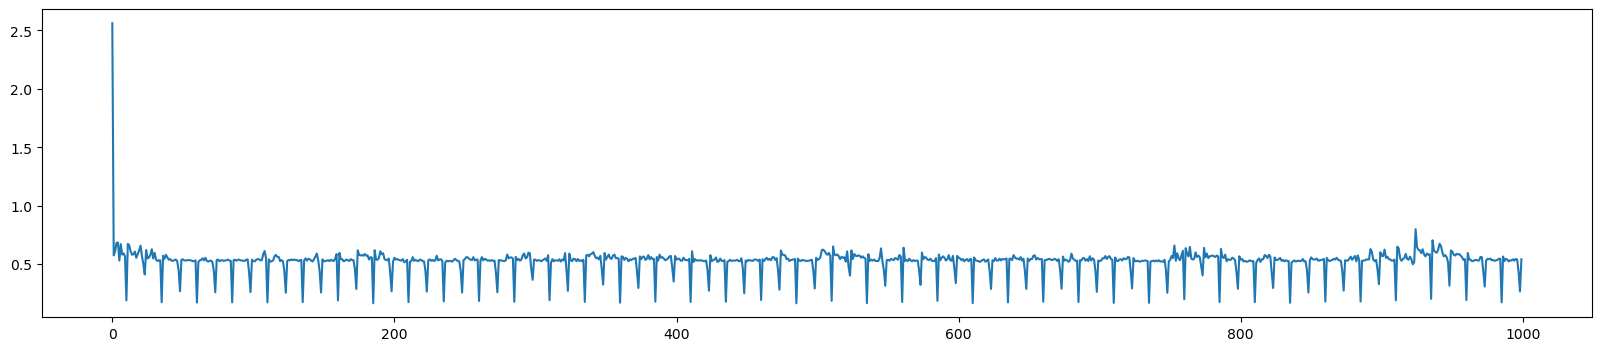

In [7]:
t0 = time()
delta_t = []
for x in fiducial_dset.take(n_batches):
    t1 = time()
    delta_t.append(t1 - t0)
    t0 = t1

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(delta_t)

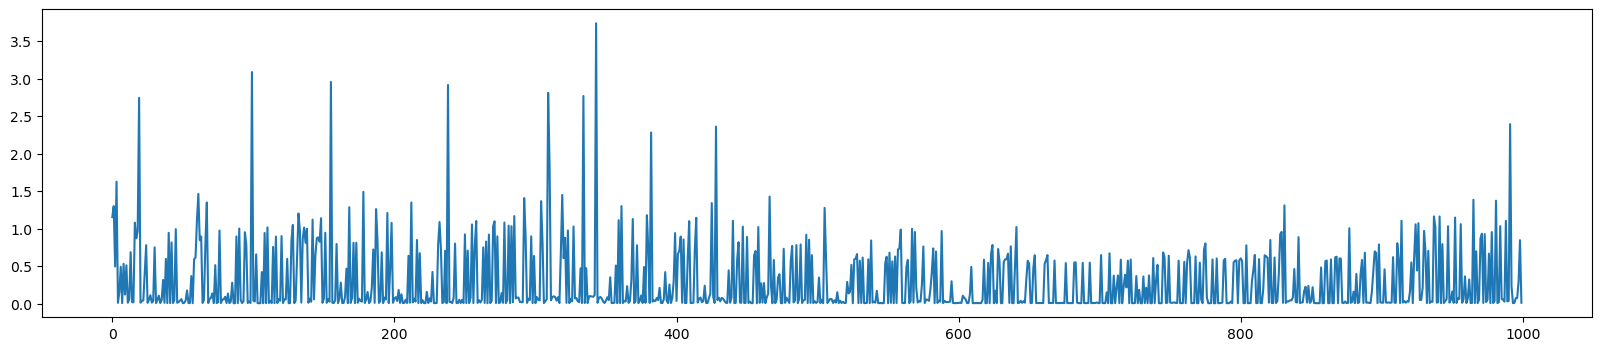

In [8]:
t0 = time()
delta_t = []
for x in multi_noise_dset.take(n_batches):
    t1 = time()
    delta_t.append(t1 - t0)
    t0 = t1

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(delta_t)

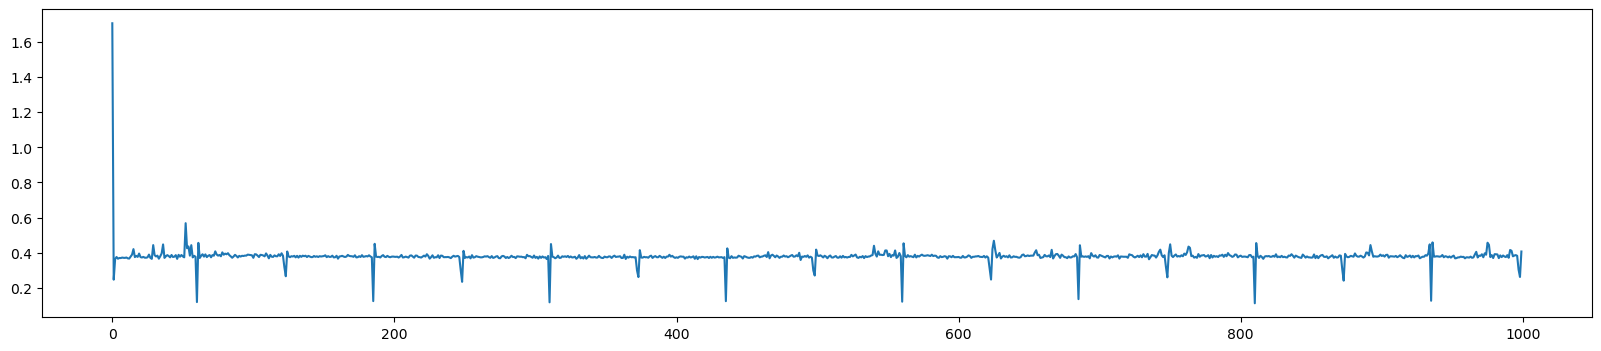

In [9]:
t0 = time()
delta_t = []
for x in kids_dset.take(n_batches):
    t1 = time()
    delta_t.append(t1 - t0)
    t0 = t1

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(delta_t)